In [1]:
import pandas as pd
pd.set_option('max_columns', None)
pd.set_option('display.max_rows', None)
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math
plt.style.use('seaborn-whitegrid')

from scipy import stats
from statsmodels.stats import weightstats as stests
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import statsmodels.formula.api as sm
from sklearn import cluster

from kmodes.kmodes import KModes
import matplotlib.pyplot as plt
%matplotlib inline
from plotnine import *
import plotnine

import pandas as pd
import plotly.express as px
import dash
import dash_core_components as dcc
import dash_html_components as html
# import dash_table
from dash import dash_table
from dash.dependencies import Input, Output
import dash_bootstrap_components as dbc
from datetime import date
import numpy as np
import plotly.graph_objects as go
from itertools import compress

<ipython-input-1-24c7135894cd>:26: UserWarning: 
The dash_core_components package is deprecated. Please replace
`import dash_core_components as dcc` with `from dash import dcc`
<ipython-input-1-24c7135894cd>:27: UserWarning: 
The dash_html_components package is deprecated. Please replace
`import dash_html_components as html` with `from dash import html`



# Data Segregation

In [2]:
data = pd.read_excel('clean_data.xlsx', index_col = 0)
data.head()

,ID,Year_Birth,Age,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Response,Complain,Country
0,1503,1976,45,PhD,Together,162397,1,1,6/3/13,31,85,1,16,2,1,2,0,0,0,1,1,0,0,0,0,0,0,0,Spain
1,1501,1982,39,PhD,Married,160803,0,0,8/4/12,21,55,16,1622,17,3,4,15,0,28,1,0,0,0,0,0,0,0,0,USA
2,5336,1971,50,Master,Together,157733,1,0,6/4/13,37,39,1,9,2,0,8,0,1,0,1,1,0,0,0,0,0,0,0,Spain
3,8475,1973,48,PhD,Married,157243,0,1,3/1/14,98,20,2,1582,1,2,1,15,0,22,0,0,0,0,0,0,0,0,0,India
4,4931,1977,44,Graduation,Together,157146,0,0,4/29/13,13,1,0,1725,2,1,1,0,0,28,0,1,0,0,0,0,0,0,0,Saudi Arabia


In [3]:
data['total_sales'] = data['MntWines'] + data['MntFruits'] + data['MntMeatProducts'] + data['MntFishProducts'] + data['MntSweetProducts'] + data['MntGoldProds']


groupby_country = data.groupby(['Country'])['total_sales'].sum().reset_index()
groupby_country['Sales Percent']=round(100*groupby_country['total_sales']/sum(groupby_country['total_sales']),2)
country_count = groupby_country['Country'].value_counts()
country_count = country_count.reset_index().rename(columns={'index':'Country', 'Country':'Count'})
country_list = groupby_country.Country
new_bubble_chart_fig = px.scatter_geo(groupby_country, 
                    locations='Country',
                    color='Country',
                    locationmode='country names', 
                    size='Sales Percent',
                    size_max=50,
                    color_discrete_map={'Spain':'DarkGreen', 'USA':'DarkSeaGreen', 'India':'wheat', 'Saudi Arabia':'crimson', 'Canada':'goldenrod', 'Germany':'Tomato', 'Australia':'lightslategray', 'Mexico':'saddlebrown'},
                    hover_name = 'Country')
new_bubble_chart_fig.update_layout(
        title_text = 'Total Product Sales by Country (in %)',
        title_x=0.45,
        showlegend = True)
new_bubble_chart_fig.update_layout({'plot_bgcolor': 'rgba(0, 0, 0, 0)','paper_bgcolor': 'rgba(0, 0, 0, 0)'})
new_bubble_chart_fig.update_layout(
    font=dict(
        size=20,
        color="DarkGreen"
    )
)

In [4]:
groupby_country.sort_values('Sales Percent', ascending = False)

,Country,total_sales,Sales Percent
6,Spain,660367,48.88
5,Saudi Arabia,210987,15.62
1,Canada,166169,12.30
0,Australia,88547,6.55
3,India,78996,5.85
2,Germany,74913,5.55
7,USA,67882,5.02
4,Mexico,3122,0.23


In [5]:

wine_sales = data.MntWines.sum()
fruit_sales = data.MntFruits.sum()
meat_sales = data.MntMeatProducts.sum()
fish_sales = data.MntFishProducts.sum()
sweets_sales = data.MntSweetProducts.sum()
gold_sales = data.MntGoldProds.sum()
total_product_sales = wine_sales + fruit_sales + meat_sales + fish_sales + sweets_sales + gold_sales
wine_sales_perc = round(wine_sales/total_product_sales*100,2)
fruit_sales_perc = round(fruit_sales/total_product_sales*100,2)
meat_sales_perc = round(meat_sales/total_product_sales*100,2)
fish_sales_perc = round(fish_sales/total_product_sales*100,2)
sweets_sales_perc = round(sweets_sales/total_product_sales*100,2)
gold_sales_perc = round(gold_sales/total_product_sales*100,2)

In [6]:
chart_fig = pd.DataFrame({'WINE':wine_sales, 'FRUITS':fruit_sales, 'MEAT': meat_sales, 'FISH':fish_sales,'SWEETS':sweets_sales,'GOLD': gold_sales},index = [0]).T
chart_fig.columns = ['Product Sales']
chart_fig.sort_values('Product Sales', ascending = False, inplace= True)


sales_demog_fig = px.bar(chart_fig)
sales_demog_fig
sales_demog_fig.update_layout({'plot_bgcolor': 'rgba(0, 0, 0, 0)','paper_bgcolor': 'rgba(0, 0, 0, 0)'})

In [7]:
demog_channel = pd.DataFrame([[data.NumDealsPurchases.sum()],[data.NumWebPurchases.sum()],[data.NumCatalogPurchases.sum()],[data.NumStorePurchases.sum()]],index = ['DEAL PURCHASES', 'WEB PURCHASES','CATALOG PURCHASES', 'STORE PURCHASES'], columns = ['Channel Sales'])
demog_channel.sort_values('Channel Sales', ascending = False)

,Channel Sales
STORE PURCHASES,12922
WEB PURCHASES,9104
CATALOG PURCHASES,5936
DEAL PURCHASES,5176


In [8]:
chart_fig['Product'] = chart_fig.index
chart_fig.groupby('Product')['Product Sales'].sum()/total_product_sales*100

Product
FISH       6.179871
FRUITS     4.335066
GOLD       7.237175
MEAT      27.577771
SWEETS     4.475556
WINE      50.194562
Name: Product Sales, dtype: float64

In [9]:
#Total Deals Accepted
data['sum_accepted'] = data['AcceptedCmp3']+data['AcceptedCmp4']+data['AcceptedCmp5']+data['AcceptedCmp1']+data['AcceptedCmp2']+data['Response']

In [10]:
#Create a Binary variable if the Customer accepted offer in any campaign
data['Accepted_binary'] = [1 if i >0 else 0 for i in data['sum_accepted']]

In [11]:
#Counts Distribution
data.groupby(by = 'Accepted_binary').ID.count()

Accepted_binary
0    1624
1     605
Name: ID, dtype: int64

In [12]:
#Dataset filtering -> Including only those customers who did not accept any offer
data_remaining = data[data['Accepted_binary']==0]

# Demographic Creation

In [13]:
#Create a column for total dependents in the home -> Demographic 1
data_remaining['no_dependents'] = data_remaining['Kidhome'] + data_remaining['Teenhome']

<ipython-input-13-650783a9774d>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [14]:
#Create a Education level of the customer -> Demographic 2
data_remaining['Education_level'] = data_remaining['Education'].map({'PhD': 'Above Graduation', 
                                                  'Master': 'Above Graduation',
                                                  'Graduation': 'Graduation',
                                                  '2n Cycle':'Below Graduation',
                                                  'Basic':'Below Graduation'})

<ipython-input-14-9f98d5b9a159>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [15]:
#Marital Status of the customer -> Demographic 3
data_remaining.Marital_Status.unique()

array(['Together', 'Married', 'Divorced', 'Single', 'Widow'], dtype=object)

In [16]:
#Create Income Levels of the customer -> Demographic 4
conditions = [
    (data_remaining['Income'] <= 40000),
    (data_remaining['Income'] > 40000) & (data_remaining['Income'] <= 60000),
    (data_remaining['Income'] > 60000)
    ]

values = ['Low Income', 'Middle Income', 'High Income']

data_remaining['Income_level'] = np.select(conditions, values)

<ipython-input-16-e5948fff18c2>:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [17]:
#Create Age Levels of the customer -> Demographic 5
bins = [1939, 1965, 1980, 1996]
name = ['Boomers', 'Gen x', 'Millennials']
data_remaining['Age_level'] = pd.cut(data_remaining['Year_Birth'], bins, labels=name)

<ipython-input-17-2e272eabac3a>:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [18]:
# Creating Clusters to understand what all demographics identify our customer base

data_clustering = data_remaining.loc[:,['no_dependents', 'Education_level', 'Income_level','Age_level','Marital_Status']]
data_clustering.head()


,no_dependents,Education_level,Income_level,Age_level,Marital_Status
0,2,Above Graduation,High Income,Gen x,Together
1,0,Above Graduation,High Income,Millennials,Married
2,1,Above Graduation,High Income,Gen x,Together
3,1,Above Graduation,High Income,Gen x,Married
4,0,Graduation,High Income,Gen x,Together


# Demographic Clustering

Cluster initiation: 1
Cluster initiation: 2
Cluster initiation: 3
Cluster initiation: 4
Cluster initiation: 5
Cluster initiation: 6
Cluster initiation: 7
Cluster initiation: 8
Cluster initiation: 9
Cluster initiation: 10
Cluster initiation: 11
Cluster initiation: 12
Cluster initiation: 13
Cluster initiation: 14
Cluster initiation: 15
Cluster initiation: 16
Cluster initiation: 17
Cluster initiation: 18
Cluster initiation: 19


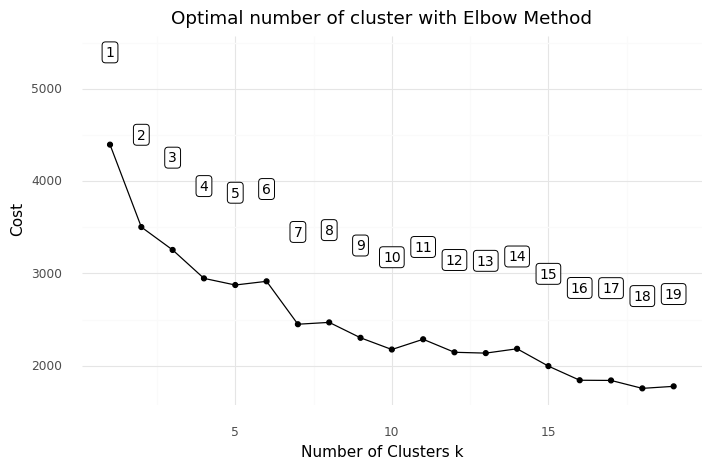

<ggplot: (8761845311094)>

In [19]:
# Choosing optimal K for K-Modes Clustering
cost = []
for cluster in range(1, 20):
    try:
        kmodes = KModes(n_jobs = -1, n_clusters = cluster, init = 'Huang', random_state = 0)
        kmodes.fit_predict(data_clustering)
        cost.append(kmodes.cost_)
        print('Cluster initiation: {}'.format(cluster))
    except:
        break
# Converting the results into a dataframe and plotting them
df_cost = pd.DataFrame({'Cluster': range(1, 20), 'Cost': cost})
# Data viz
plotnine.options.figure_size = (8, 4.8)
(
    ggplot(data = df_cost)+
    geom_line(aes(x = 'Cluster',
                  y = 'Cost'))+
    geom_point(aes(x = 'Cluster',
                   y = 'Cost'))+
    geom_label(aes(x = 'Cluster',
                   y = 'Cost',
                   label = 'Cluster'),
               size = 10,
               nudge_y = 1000) +
    labs(title = 'Optimal number of cluster with Elbow Method')+
    xlab('Number of Clusters k')+
    ylab('Cost')+
    theme_minimal()
)

In [20]:
kmodes = KModes(n_jobs = -1, n_clusters = 3, init = 'Huang', random_state = 0)
cluster = kmodes.fit_predict(data_clustering)

data_clustering['Cluster'] = cluster
data_remaining['Cluster'] = cluster

<ipython-input-20-0b93e070efb9>:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [21]:
data_clustering.groupby(by = 'Cluster').agg(pd.Series.mode)

,no_dependents,Education_level,Income_level,Age_level,Marital_Status
Cluster,,,,,
0,1,Graduation,Low Income,Gen x,Married
1,1,Graduation,Middle Income,Gen x,Single
2,0,Graduation,High Income,Boomers,Married


In [22]:
data_clustering.Cluster.value_counts(normalize = True)

0    0.530788
2    0.246921
1    0.222291
Name: Cluster, dtype: float64

# Customer Segmentation

In [23]:
data_remaining['Sales_Total'] = (data_remaining['MntWines'] +  data_remaining['MntFruits'] + data_remaining['MntMeatProducts'] + data_remaining['MntFishProducts'] + data_remaining['MntSweetProducts'] + data_remaining['MntGoldProds'])

<ipython-input-23-379be2024edf>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [24]:
data_remaining.Sales_Total.groupby(pd.qcut(data_remaining.Sales_Total, q = 3)).count()

Sales_Total
(4.999, 76.0]      542
(76.0, 576.0]      544
(576.0, 2440.0]    538
Name: Sales_Total, dtype: int64

In [25]:
conditions = [
    (data_remaining['Sales_Total'] <= 76.0),
    (data_remaining['Sales_Total'] > 76.0) & (data_remaining['Sales_Total'] <= 576.0),
    (data_remaining['Sales_Total'] > 576.0)
    ]

values = ['Low Sales', 'Medium Sales', 'High Sales']

data_remaining['Sales_Total_level'] = np.select(conditions, values)

<ipython-input-25-b7235876220f>:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [26]:
data_remaining.groupby(['Sales_Total_level','Income_level']).agg({'ID': 'count'})

ID
Sales_Total_level Income_level      
High Sales        High Income    424
                  Low Income       3
                  Middle Income  111
Low Sales         High Income      4
                  Low Income     427
                  Middle Income  111
Medium Sales      High Income     62
                  Low Income     182
                  Middle Income  300

In [27]:
data_remaining.groupby(['Sales_Total_level','Age_level']).agg({'ID': 'count'})

ID
Sales_Total_level Age_level       
High Sales        Boomers      244
                  Gen x        231
                  Millennials   63
Low Sales         Boomers      143
                  Gen x        277
                  Millennials  122
Medium Sales      Boomers      220
                  Gen x        244
                  Millennials   80

In [28]:
data_remaining.groupby(['Sales_Total_level','Marital_Status']).agg({'ID': 'count'})

ID
Sales_Total_level Marital_Status     
High Sales        Divorced         60
                  Married         205
                  Single          100
                  Together        150
                  Widow            23
Low Sales         Divorced         60
                  Married         215
                  Single          120
                  Together        135
                  Widow            12
Medium Sales      Divorced         42
                  Married         227
                  Single          111
                  Together        149
                  Widow            15

In [29]:
data_remaining.groupby(['Sales_Total_level','no_dependents']).agg({'ID': 'count'})

ID
Sales_Total_level no_dependents     
High Sales        0              216
                  1              275
                  2               43
                  3                4
Low Sales         0               57
                  1              295
                  2              166
                  3               24
Medium Sales      0               79
                  1              317
                  2              130
                  3               18

In [30]:
data_remaining.groupby(['Sales_Total_level','Education_level']).agg({'ID': 'count'})

ID
Sales_Total_level Education_level      
High Sales        Above Graduation  199
                  Below Graduation   43
                  Graduation        296
Low Sales         Above Graduation  176
                  Below Graduation   99
                  Graduation        267
Medium Sales      Above Graduation  220
                  Below Graduation   60
                  Graduation        264

In [31]:
data_remaining.groupby(['Sales_Total_level','Age_level','Income_level','Marital_Status']).agg({'ID': 'count'})

ID
Sales_Total_level Age_level   Income_level  Marital_Status    
High Sales        Boomers     High Income   Divorced        23
                                            Married         72
                                            Single          30
                                            Together        54
                                            Widow           12
                              Low Income    Divorced         0
                                            Married          0
                                            Single           0
                                            Together         0
                                            Widow            0
                              Middle Income Divorced         7
                                            Married         16
                                            Single          10
                                            Together        15
                                            Widow            5
                  Gen x       High Income   Divorced        24
                                            Married         77
                                            Single          29
                                            Together        47
                                            Widow            3
                              Low Income    Divorced         0
                                            Married          2
                                            Single           0
                                            Together         0
                                            Widow            0
                              Middle Income Divorced         4
                                            Married         17
                                            Single          11
                                            Together        14
                                            Widow            3
                  Millennials High Income   Divorced         2
                                            Married         16
                                            Single          17
                                            Together        18
                                            Widow            0
                              Low Income    Divorced         0
                                            Married          1
                                            Single           0
                                            Together         0
                                            Widow            0
                              Middle Income Divorced         0
                                            Married          4
                                            Single           3
                                            Together         2
                                            Widow            0
Low Sales         Boomers     High Income   Divorced         0
                                            Married          1
                                            Single           0
                                            Together         0
                                            Widow            0
                              Low Income    Divorced        15
                                            Married         35
                                            Single          16
                                            Together        28
                                            Widow            2
                              Middle Income Divorced         5
                                            Married         15
                                            Single          13
                                            Together        10
                                            Widow            3
                  Gen x       High Income   Divorced         1
                                            Married          0
                            

# Channel Usage by Each Customer Segment

In [32]:
data_remaining.columns

Index(['ID', 'Year_Birth', 'Age', 'Education', 'Marital_Status', 'Income',
       'Kidhome', 'Teenhome', 'Dt_Customer', 'Recency', 'MntWines',
       'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts',
       'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases',
       'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth',
       'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1',
       'AcceptedCmp2', 'Response', 'Complain', 'Country', 'total_sales',
       'sum_accepted', 'Accepted_binary', 'no_dependents', 'Education_level',
       'Income_level', 'Age_level', 'Cluster', 'Sales_Total',
       'Sales_Total_level'],
      dtype='object')

In [33]:
data_remaining['Total_purchases'] = (data_remaining['NumDealsPurchases'] +  data_remaining['NumWebPurchases'] + data_remaining['NumCatalogPurchases'] + data_remaining['NumStorePurchases'])
data_remaining.describe()


<ipython-input-33-69c09954c8da>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,ID,Year_Birth,Age,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Response,Complain,total_sales,sum_accepted,Accepted_binary,no_dependents,Cluster,Sales_Total,Total_purchases
count,1624.000000,1624.000000,1624.000000,1624.000000,1624.000000,1624.000000,1624.000000,1624.000000,1624.000000,1624.000000,1624.000000,1624.000000,1624.000000,1624.000000,1624.000000,1624.000000,1624.000000,1624.000000,1624.0,1624.0,1624.0,1624.0,1624.0,1624.0,1624.000000,1624.000000,1624.0,1624.0,1624.000000,1624.000000,1624.000000,1624.000000
mean,5664.244458,1969.118842,51.881158,48330.756158,0.499384,0.549261,50.960591,216.939655,22.774015,125.895936,32.059729,22.996305,37.901478,2.360837,3.717365,2.118227,5.489532,5.421182,0.0,0.0,0.0,0.0,0.0,0.0,0.010468,458.567118,0.0,0.0,1.048645,0.716133,458.567118,13.685961
std,3271.201897,11.470879,11.470879,20298.557154,0.551701,0.543861,28.637681,258.106838,37.062835,187.716047,49.856326,37.914438,48.273062,1.933355,2.761105,2.736227,3.196176,2.357185,0.0,0.0,0.0,0.0,0.0,0.0,0.101808,494.101713,0.0,0.0,0.732637,0.835200,494.101713,7.657319
min,0.000000,1940.000000,26.000000,1730.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,5.000000,0.0,0.0,0.000000,0.000000,5.000000,0.000000
25%,2867.750000,1960.000000,44.000000,33249.000000,0.000000,0.000000,27.000000,18.000000,1.000000,12.000000,2.000000,1.000000,6.000000,1.000000,2.000000,0.000000,3.000000,4.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,55.000000,0.0,0.0,1.000000,0.000000,55.000000,7.000000
50%,5570.500000,1970.000000,51.000000,47352.000000,0.000000,1.000000,51.000000,97.500000,6.000000,45.000000,10.000000,7.000000,18.000000,2.000000,3.000000,1.000000,4.000000,6.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,234.000000,0.0,0.0,1.000000,0.000000,234.000000,12.000000
75%,8569.750000,1977.000000,61.000000,63414.750000,1.000000,1.000000,76.000000,359.750000,26.000000,161.000000,38.000000,26.000000,49.000000,3.000000,5.000000,3.000000,8.000000,7.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,806.500000,0.0,0.0,1.000000,1.000000,806.500000,20.000000
max,11191.000000,1995.000000,81.000000,162397.000000,2.000000,2.000000,99.000000,1396.000000,199.000000,1725.000000,259.000000,263.000000,362.000000,15.000000,27.000000,28.000000,13.000000,20.000000,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,2440.000000,0.0,0.0,3.000000,2.000000,2440.000000,44.000000


In [34]:
data_remaining['deals_new'] = data_remaining['NumDealsPurchases'] + 0.7
data_remaining['web_new'] = data_remaining['NumWebPurchases'] + 0.7
data_remaining['catalog_new'] = data_remaining['NumCatalogPurchases'] + 0.7
data_remaining['stores_new'] = data_remaining['NumStorePurchases'] + 0.7

data_remaining['log_sales'] = [math.log(i) for i in data_remaining['Sales_Total']]
data_remaining['log_deals'] = [math.log(i) for i in data_remaining['deals_new']]
data_remaining['log_web'] = [math.log(i) for i in data_remaining['web_new']]
data_remaining['log_catalog'] = [math.log(i) for i in data_remaining['catalog_new']]
data_remaining['log_stores'] = [math.log(i) for i in data_remaining['stores_new']]

<ipython-input-34-6888927d141b>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-34-6888927d141b>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-34-6888927d141b>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-34-6888927

In [35]:
reg_model = sm.ols(formula="log_sales ~ log_web + log_catalog + log_stores + log_deals", data=data_remaining[data_remaining.Income_level == 'High Income']).fit()
print(reg_model.summary())

                            OLS Regression Results                            
Dep. Variable:              log_sales   R-squared:                       0.642
Model:                            OLS   Adj. R-squared:                  0.639
Method:                 Least Squares   F-statistic:                     217.1
Date:                Sun, 12 Dec 2021   Prob (F-statistic):          1.33e-106
Time:                        14:47:40   Log-Likelihood:                -217.67
No. Observations:                 490   AIC:                             445.3
Df Residuals:                     485   BIC:                             466.3
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       4.3831      0.102     43.017      

In [36]:
reg_model = sm.ols(formula="log_sales ~ log_web + log_catalog + log_stores + log_deals", data=data_remaining[data_remaining.Income_level == 'Low Income']).fit()
print(reg_model.summary())

                            OLS Regression Results                            
Dep. Variable:              log_sales   R-squared:                       0.745
Model:                            OLS   Adj. R-squared:                  0.743
Method:                 Least Squares   F-statistic:                     442.4
Date:                Sun, 12 Dec 2021   Prob (F-statistic):          2.79e-178
Time:                        14:47:40   Log-Likelihood:                -364.50
No. Observations:                 612   AIC:                             739.0
Df Residuals:                     607   BIC:                             761.1
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       2.4320      0.083     29.185      

In [37]:
reg_model = sm.ols(formula="log_sales ~ log_web + log_catalog + log_stores + log_deals", data=data_remaining[data_remaining.Income_level == 'Middle Income']).fit()
print(reg_model.summary())

                            OLS Regression Results                            
Dep. Variable:              log_sales   R-squared:                       0.942
Model:                            OLS   Adj. R-squared:                  0.941
Method:                 Least Squares   F-statistic:                     2097.
Date:                Sun, 12 Dec 2021   Prob (F-statistic):          7.37e-318
Time:                        14:47:40   Log-Likelihood:                -50.737
No. Observations:                 522   AIC:                             111.5
Df Residuals:                     517   BIC:                             132.8
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       2.3984      0.057     41.903      

In [38]:
data_remaining['log_income'] = [math.log(i) for i in data_remaining['Income']]

<ipython-input-38-3ca1f733bace>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [39]:
reg_model = sm.ols(formula="log_sales ~ log_web + log_catalog + log_stores + log_deals + log_income", data=data_remaining[data_remaining.Sales_Total_level == 'High Sales']).fit()
print(reg_model.summary())

                            OLS Regression Results                            
Dep. Variable:              log_sales   R-squared:                       0.337
Model:                            OLS   Adj. R-squared:                  0.331
Method:                 Least Squares   F-statistic:                     54.18
Date:                Sun, 12 Dec 2021   Prob (F-statistic):           1.83e-45
Time:                        14:47:40   Log-Likelihood:                -21.095
No. Observations:                 538   AIC:                             54.19
Df Residuals:                     532   BIC:                             79.92
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       3.5303      0.622      5.678      

In [40]:
reg_model = sm.ols(formula="log_sales ~ log_web + log_catalog + log_stores + log_income + log_deals", data=data_remaining[data_remaining.Sales_Total_level == 'Medium Sales']).fit()
print(reg_model.summary())

                            OLS Regression Results                            
Dep. Variable:              log_sales   R-squared:                       0.830
Model:                            OLS   Adj. R-squared:                  0.828
Method:                 Least Squares   F-statistic:                     523.9
Date:                Sun, 12 Dec 2021   Prob (F-statistic):          4.48e-204
Time:                        14:47:40   Log-Likelihood:                -17.271
No. Observations:                 544   AIC:                             46.54
Df Residuals:                     538   BIC:                             72.34
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       3.6614      0.341     10.725      

In [41]:
reg_model = sm.ols(formula="log_sales ~ log_web + log_catalog + log_stores + log_deals + log_income", data=data_remaining[data_remaining.Sales_Total_level == 'Low Sales']).fit()
print(reg_model.summary())

                            OLS Regression Results                            
Dep. Variable:              log_sales   R-squared:                       0.630
Model:                            OLS   Adj. R-squared:                  0.626
Method:                 Least Squares   F-statistic:                     182.2
Date:                Sun, 12 Dec 2021   Prob (F-statistic):          4.30e-113
Time:                        14:47:40   Log-Likelihood:                -158.75
No. Observations:                 542   AIC:                             329.5
Df Residuals:                     536   BIC:                             355.3
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       0.8256      0.340      2.430      

# Customers who already Accepted the campaign

In [42]:
data_accepted = data[data['Accepted_binary']==1]

In [43]:
data_accepted['Sales_Total'] = data_accepted['MntWines'] +  data_accepted['MntFruits'] + data_accepted['MntMeatProducts'] + data_accepted['MntFishProducts'] + data_accepted['MntSweetProducts'] + data_accepted['MntGoldProds']

<ipython-input-43-8678dbcfd629>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



# Channel Usage by Customer Segment for Interacting Customer

In [44]:
conditions = [
    (data_accepted['Income'] <= 40000),
    (data_accepted['Income'] > 40000) & (data_accepted['Income'] <= 60000),
    (data_accepted['Income'] > 60000)
    ]

values = ['Low Income', 'Middle Income', 'High Income']

data_accepted['Income_level'] = np.select(conditions, values)

<ipython-input-44-e16142205479>:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [45]:
data_accepted['deals_new'] = data_accepted['NumDealsPurchases'] + 0.7
data_accepted['web_new'] = data_accepted['NumWebPurchases'] + 0.7
data_accepted['catalog_new'] = data_accepted['NumCatalogPurchases'] + 0.7
data_accepted['stores_new'] = data_accepted['NumStorePurchases'] + 0.7

data_accepted['log_sales'] = [math.log(i) for i in data_accepted['Sales_Total']]
data_accepted['log_deals'] = [math.log(i) for i in data_accepted['deals_new']]
data_accepted['log_web'] = [math.log(i) for i in data_accepted['web_new']]
data_accepted['log_catalog'] = [math.log(i) for i in data_accepted['catalog_new']]
data_accepted['log_stores'] = [math.log(i) for i in data_accepted['stores_new']]

<ipython-input-45-18454eebb16a>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-45-18454eebb16a>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-45-18454eebb16a>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-45-18454ee

In [46]:
data_accepted['log_income'] = [math.log(i) for i in data_accepted['Income']]
data_accepted['log_age'] = [math.log(i) for i in data_accepted['Age']]

<ipython-input-46-574f3435688a>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-46-574f3435688a>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [47]:
reg_model = sm.ols(formula="log_sales ~ NumStorePurchases + NumCatalogPurchases + NumWebPurchases + NumDealsPurchases", data=data_accepted[data_accepted.Income_level == 'High Income']).fit()
print(reg_model.summary())

                            OLS Regression Results                            
Dep. Variable:              log_sales   R-squared:                       0.161
Model:                            OLS   Adj. R-squared:                  0.151
Method:                 Least Squares   F-statistic:                     16.26
Date:                Sun, 12 Dec 2021   Prob (F-statistic):           3.38e-12
Time:                        14:47:40   Log-Likelihood:                -106.17
No. Observations:                 345   AIC:                             222.3
Df Residuals:                     340   BIC:                             241.6
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               7.1849    

In [48]:
reg_model = sm.ols(formula="log_sales ~ NumStorePurchases + NumCatalogPurchases + NumWebPurchases + NumDealsPurchases", data=data_accepted[data_accepted.Income_level == 'Middle Income']).fit()
print(reg_model.summary())

                            OLS Regression Results                            
Dep. Variable:              log_sales   R-squared:                       0.743
Model:                            OLS   Adj. R-squared:                  0.735
Method:                 Least Squares   F-statistic:                     99.69
Date:                Sun, 12 Dec 2021   Prob (F-statistic):           1.04e-39
Time:                        14:47:40   Log-Likelihood:                -84.671
No. Observations:                 143   AIC:                             179.3
Df Residuals:                     138   BIC:                             194.2
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               4.2080    

In [49]:
reg_model = sm.ols(formula="log_sales ~ NumStorePurchases + NumCatalogPurchases + NumWebPurchases + NumDealsPurchases", data=data_accepted[data_accepted.Income_level == 'Low Income']).fit()
print(reg_model.summary())

                            OLS Regression Results                            
Dep. Variable:              log_sales   R-squared:                       0.863
Model:                            OLS   Adj. R-squared:                  0.858
Method:                 Least Squares   F-statistic:                     176.8
Date:                Sun, 12 Dec 2021   Prob (F-statistic):           2.01e-47
Time:                        14:47:40   Log-Likelihood:                -36.412
No. Observations:                 117   AIC:                             82.82
Df Residuals:                     112   BIC:                             96.64
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               2.9377    

In [50]:
reg_model = sm.ols(formula="Sales_Total ~ AcceptedCmp1 + AcceptedCmp2 + AcceptedCmp3 + AcceptedCmp4 + AcceptedCmp5 + Response", data=data_accepted).fit()
print(reg_model.summary())

                            OLS Regression Results                            
Dep. Variable:            Sales_Total   R-squared:                       0.384
Model:                            OLS   Adj. R-squared:                  0.378
Method:                 Least Squares   F-statistic:                     62.24
Date:                Sun, 12 Dec 2021   Prob (F-statistic):           6.63e-60
Time:                        14:47:40   Log-Likelihood:                -4659.8
No. Observations:                 605   AIC:                             9334.
Df Residuals:                     598   BIC:                             9364.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept      814.9813     49.255     16.546   

In [51]:
reg_model = sm.ols(formula="Sales_Total ~ AcceptedCmp1 + AcceptedCmp5 ", data=data_accepted).fit()
print(reg_model.summary())

                            OLS Regression Results                            
Dep. Variable:            Sales_Total   R-squared:                       0.364
Model:                            OLS   Adj. R-squared:                  0.362
Method:                 Least Squares   F-statistic:                     172.1
Date:                Sun, 12 Dec 2021   Prob (F-statistic):           7.69e-60
Time:                        14:47:40   Log-Likelihood:                -4669.8
No. Observations:                 605   AIC:                             9346.
Df Residuals:                     602   BIC:                             9359.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept      704.2066     27.501     25.607   

In [52]:
reg_model = sm.ols(formula="log_sales ~ NumStorePurchases + NumCatalogPurchases + NumWebPurchases + NumDealsPurchases", data=data_accepted[data_accepted.AcceptedCmp1 == 1]).fit()
print(reg_model.summary())

                            OLS Regression Results                            
Dep. Variable:              log_sales   R-squared:                       0.287
Model:                            OLS   Adj. R-squared:                  0.266
Method:                 Least Squares   F-statistic:                     13.87
Date:                Sun, 12 Dec 2021   Prob (F-statistic):           1.56e-09
Time:                        14:47:40   Log-Likelihood:                -57.098
No. Observations:                 143   AIC:                             124.2
Df Residuals:                     138   BIC:                             139.0
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               7.0578    

In [53]:
reg_model = sm.ols(formula="log_sales ~ NumStorePurchases + NumCatalogPurchases + NumWebPurchases + NumDealsPurchases", data=data_accepted[data_accepted.AcceptedCmp2 == 1]).fit()
print(reg_model.summary())

                            OLS Regression Results                            
Dep. Variable:              log_sales   R-squared:                       0.441
Model:                            OLS   Adj. R-squared:                  0.352
Method:                 Least Squares   F-statistic:                     4.934
Date:                Sun, 12 Dec 2021   Prob (F-statistic):            0.00452
Time:                        14:47:40   Log-Likelihood:                -31.353
No. Observations:                  30   AIC:                             72.71
Df Residuals:                      25   BIC:                             79.71
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               5.1494    

In [54]:
reg_model = sm.ols(formula="log_sales ~ NumStorePurchases + NumCatalogPurchases + NumWebPurchases + NumDealsPurchases", data=data_accepted[data_accepted.AcceptedCmp3 == 1]).fit()
print(reg_model.summary())

                            OLS Regression Results                            
Dep. Variable:              log_sales   R-squared:                       0.823
Model:                            OLS   Adj. R-squared:                  0.819
Method:                 Least Squares   F-statistic:                     183.0
Date:                Sun, 12 Dec 2021   Prob (F-statistic):           5.06e-58
Time:                        14:47:40   Log-Likelihood:                -155.76
No. Observations:                 162   AIC:                             321.5
Df Residuals:                     157   BIC:                             337.0
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               3.3969    

In [55]:
reg_model = sm.ols(formula="log_sales ~ NumStorePurchases + NumCatalogPurchases + NumWebPurchases + NumDealsPurchases", data=data_accepted[data_accepted.AcceptedCmp4 == 1]).fit()
print(reg_model.summary())

                            OLS Regression Results                            
Dep. Variable:              log_sales   R-squared:                       0.452
Model:                            OLS   Adj. R-squared:                  0.439
Method:                 Least Squares   F-statistic:                     33.41
Date:                Sun, 12 Dec 2021   Prob (F-statistic):           2.59e-20
Time:                        14:47:40   Log-Likelihood:                -133.83
No. Observations:                 167   AIC:                             277.7
Df Residuals:                     162   BIC:                             293.3
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               5.7235    

In [56]:
reg_model = sm.ols(formula="log_sales ~ NumStorePurchases + NumCatalogPurchases + NumWebPurchases + NumDealsPurchases", data=data_accepted[data_accepted.AcceptedCmp5 == 1]).fit()
print(reg_model.summary())

                            OLS Regression Results                            
Dep. Variable:              log_sales   R-squared:                       0.040
Model:                            OLS   Adj. R-squared:                  0.015
Method:                 Least Squares   F-statistic:                     1.628
Date:                Sun, 12 Dec 2021   Prob (F-statistic):              0.170
Time:                        14:47:40   Log-Likelihood:                -30.665
No. Observations:                 161   AIC:                             71.33
Df Residuals:                     156   BIC:                             86.74
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               7.4435    

In [57]:
reg_model = sm.ols(formula="log_sales ~ NumStorePurchases + NumCatalogPurchases + NumWebPurchases + NumDealsPurchases", data=data_accepted[data_accepted.Response == 1]).fit()
print(reg_model.summary())

                            OLS Regression Results                            
Dep. Variable:              log_sales   R-squared:                       0.725
Model:                            OLS   Adj. R-squared:                  0.721
Method:                 Least Squares   F-statistic:                     214.5
Date:                Sun, 12 Dec 2021   Prob (F-statistic):           5.96e-90
Time:                        14:47:40   Log-Likelihood:                -336.24
No. Observations:                 331   AIC:                             682.5
Df Residuals:                     326   BIC:                             701.5
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               4.0587    

# Regression - Prediction 

In [58]:
reg_model = sm.ols(formula="Sales_Total ~ Income + NumStorePurchases + NumCatalogPurchases + NumWebPurchases", data=data_remaining).fit()
print(reg_model.summary())

                            OLS Regression Results                            
Dep. Variable:            Sales_Total   R-squared:                       0.815
Model:                            OLS   Adj. R-squared:                  0.815
Method:                 Least Squares   F-statistic:                     1785.
Date:                Sun, 12 Dec 2021   Prob (F-statistic):               0.00
Time:                        14:47:40   Log-Likelihood:                -11006.
No. Observations:                1624   AIC:                         2.202e+04
Df Residuals:                    1619   BIC:                         2.205e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept            -297.2996    

In [67]:
data['Sales_Total'] = (data['MntWines'] +  data['MntFruits'] + data['MntMeatProducts'] + data['MntFishProducts'] + data['MntSweetProducts'] + data['MntGoldProds'])

data['web_new'] = data['NumWebPurchases'] + 0.7
data['catalog_new'] = data['NumCatalogPurchases'] + 0.7
data['stores_new'] = data['NumStorePurchases'] + 0.7

data['log_sales'] = [math.log(i) for i in data['Sales_Total']]
data['log_web'] = [math.log(i) for i in data['web_new']]
data['log_catalog'] = [math.log(i) for i in data['catalog_new']]
data['log_stores'] = [math.log(i) for i in data['stores_new']]
data['log_income'] = [math.log(i) for i in data['Income']]

In [68]:
reg_model = sm.ols(formula=" Sales_Total ~ Income + NumStorePurchases + NumCatalogPurchases + NumWebPurchases + NumDealsPurchases + AcceptedCmp1 + AcceptedCmp2 + AcceptedCmp3 + AcceptedCmp4 + AcceptedCmp5 + Response", data=data).fit()
print(reg_model.summary())

                            OLS Regression Results                            
Dep. Variable:            Sales_Total   R-squared:                       0.805
Model:                            OLS   Adj. R-squared:                  0.804
Method:                 Least Squares   F-statistic:                     833.9
Date:                Sun, 12 Dec 2021   Prob (F-statistic):               0.00
Time:                        15:59:50   Log-Likelihood:                -15606.
No. Observations:                2229   AIC:                         3.124e+04
Df Residuals:                    2217   BIC:                         3.130e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept            -321.4156    

In [70]:
reg_model = sm.ols(formula=" log_sales ~ log_income + log_stores + log_catalog + log_web", data=data).fit()
print(reg_model.summary())

                            OLS Regression Results                            
Dep. Variable:              log_sales   R-squared:                       0.911
Model:                            OLS   Adj. R-squared:                  0.911
Method:                 Least Squares   F-statistic:                     5722.
Date:                Sun, 12 Dec 2021   Prob (F-statistic):               0.00
Time:                        16:01:32   Log-Likelihood:                -1340.5
No. Observations:                2229   AIC:                             2691.
Df Residuals:                    2224   BIC:                             2720.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      -1.4875      0.278     -5.351      